<a href="https://colab.research.google.com/github/jsebastianquiroga/Unal_cursos/blob/main/Analitica%20/2_Analisis_sentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Sentimientos en Python

Modelo de asignación de Dirichlet latente (LDA)

La comunicación en redes sociales, especialmente en Twitter, ha sido una herramienta fundamental en la estrategia de comunicación del expresidente de los Estados Unidos, Donald Trump ha utilizado esta plataforma para compartir sus opiniones, hacer anuncios políticos y comunicarse directamente con sus seguidores. En este análisis, aplicaremos el modelo de asignación de Dirichlet latente (LDA, por sus siglas en inglés) para explorar y comprender las temáticas principales en los tweets de Donald Trump durante este período.

El LDA es un modelo generativo probabilístico que permite descubrir temas ocultos en grandes conjuntos de texto. Este enfoque es útil para analizar los patrones y temáticas subyacentes en los mensajes de Trump en Twitter, lo que nos permitirá obtener una visión más profunda de sus prioridades, intereses y enfoques comunicativos a lo largo de los años.

En primer lugar, realizaremos una limpieza y preprocesamiento de los datos para prepararlos para el análisis de LDA. Esto incluye la eliminación de palabras vacías, enlaces y caracteres especiales, así como la tokenización de los tweets. Posteriormente, aplicaremos el modelo LDA para identificar las temáticas predominantes en el conjunto de datos. Analizaremos la evolución de estos temas a lo largo del tiempo y su relación con eventos políticos y sociales relevantes.

Al final del análisis, presentaremos las conclusiones y discutiremos el impacto de estos temas en la percepción pública de Trump y su papel en la política estadounidense. Este estudio proporcionará una visión valiosa sobre la estrategia de comunicación de Trump en Twitter y cómo ha utilizado la plataforma para influir en el discurso público y político durante su mandato y más allá.








In [1]:
import pandas as pd
# Conexion a gdrive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth

from oauth2client.client import GoogleCredentials

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Booksummaries_share = '1PMxePFe_6CEXeIye0lTJHB43ZMgMa5EC'
download = drive.CreateFile({'id': Booksummaries_share})
download.GetContentFile('Trump_Tweets.csv')


df_tweets = pd.read_csv("Trump_Tweets.csv")

df_tweets

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f
...,...,...,...,...,...,...,...,...,...
56566,1319485303363571714,RT @RandPaul: I don’t know why @JoeBiden think...,t,f,Twitter for iPhone,0,20683,2020-10-23 03:46:25,f
56567,1319484210101379072,RT @EliseStefanik: President @realDonaldTrump ...,t,f,Twitter for iPhone,0,9869,2020-10-23 03:42:05,f
56568,1319444420861829121,RT @TeamTrump: LIVE: Presidential Debate #Deba...,t,f,Twitter for iPhone,0,8197,2020-10-23 01:03:58,f
56569,1319384118849949702,Just signed an order to support the workers of...,f,f,Twitter for iPhone,176289,36001,2020-10-22 21:04:21,f


In [3]:
df_tweets.dat = pd.to_datetime(df_tweets.date)
print('Fecha del primer tweet de la base: ',df_tweets.dat.min())
print('Fecha del ultimo tweet de la base: ',df_tweets.dat.max())

Fecha del primer tweet de la base:  2009-05-04 18:54:25
Fecha del ultimo tweet de la base:  2021-01-08 15:44:28


<ipython-input-3-e0bc97f4522f>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_tweets.dat = pd.to_datetime(df_tweets.date)


In [4]:
# Importa la librería NLTK (Natural Language Toolkit)
# Importa el conjunto de palabras vacías (stopwords) desde el módulo 'corpus' de NLTK
import nltk
from nltk.corpus import stopwords

# Descarga el conjunto de palabras vacías en inglés
nltk.download('stopwords')

# Crea un conjunto de palabras vacías en inglés
en_stop_words = set(stopwords.words('english'))

# Muestra las primeras 10 palabras vacías del conjunto en inglés
list(en_stop_words)[:10]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['by',
 "needn't",
 'don',
 'ain',
 'we',
 "doesn't",
 'hasn',
 'out',
 "shouldn't",
 "didn't"]

In [5]:
# Importa las bibliotecas y módulos necesarios
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import re
import math

# Define una función para limpiar y preprocesar los tweets
def clean_tweets(df,
                 tweet_col='text',
                 date_col='date',
                 start_datetime=datetime(2017,1,20, 0, 0, 0)
                ):

    df_copy = df.copy()
    # Elimina filas con valores vacíos
    df_copy.dropna(inplace=True)
    # Formatea la fecha
    df_copy[date_col] = df_copy[date_col].apply(lambda row: datetime.strptime(row, '%Y-%m-%d %H:%M:%S'))
    # Filtra filas anteriores a una fecha dada
    df_copy = df_copy[df_copy[date_col] >= start_datetime]
    # Convierte los tweets a minúsculas
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    # Filtra palabras vacías y URLs
    en_stop_words = set(stopwords.words('english'))
    extended_stop_words = en_stop_words | \
                        {
                            '&amp;', 'rt',  'amp',
                            'th','co', 're', 've', 'kim', 'daca',
                            '@realdonaldtrump', 'president', 'trump'
                        }
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (not word in extended_stop_words) and (not re.match(url_re, word))]))

    # Tokeniza los tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))

    return df_copy

# Define una función para obtener las palabras más frecuentes en un texto
def get_most_freq_words(str, n=None):
    # Ajusta y transforma el texto usando CountVectorizer
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)

    # Suma la frecuencia de las palabras en el conjunto de datos
    sum_words = bag_of_words.sum(axis=0)

    # Crea una lista de tuplas que contiene las palabras y sus frecuencias
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]

    # Ordena la lista de palabras por frecuencia
    freq = sorted(freq, key=lambda x: x[1], reverse=True)

    # Retorna las primeras n palabras más frecuentes
    return freq[:n]

# Limpia y preprocesa los tweets
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head()

# Obtiene las 10 palabras más frecuentes en los tweets de Trump limpios y tokenizados
print(get_most_freq_words([word for tweet in df_tweets_clean.tokenized_text for word in tweet], 10))

[('great', 3834), ('people', 2205), ('amp', 2109), ('democrats', 1739), ('thank', 1672), ('news', 1560), ('realdonaldtrump', 1508), ('country', 1410), ('big', 1335), ('new', 1320)]


La métrica de coherencia nos proporciona una medida cuantitativa de qué tan coherente y separados están los temas identificados en un modelo de tópicos. Esta métrica evalúa la calidad del modelo basándose en la similitud semántica de las palabras que conforman cada tema. Cuanto más distintas sean las palabras entre los diferentes temas, menos relación habrá entre estos temas y, por tanto, mayor coherencia tendrá el modelo.

En otras palabras, un modelo con una alta coherencia implica que los temas identificados están bien definidos y separados, lo que facilita su interpretación y análisis. Por el contrario, un modelo con una baja coherencia sugiere que los temas identificados pueden estar solapándose o mezclándose, lo que dificulta la comprensión de las temáticas subyacentes en el conjunto de datos.

Al calcular la coherencia para diferentes números de temas, podemos identificar el número óptimo de temas que maximiza la coherencia del modelo. Esto nos permite seleccionar el modelo que mejor captura y representa las temáticas principales presentes en los datos analizados.

In [6]:
# Construye un diccionario donde, para cada tweet, cada palabra tiene su propio ID
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# Construye el corpus, es decir, vectores con el número de ocurrencias de cada palabra por tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

# Calcula la coherencia
tweets_coherence = []
for nb_topics in range(1, 10):
    # Entrena el modelo LDA con un número específico de temas
    lda = LdaModel(tweets_corpus, num_topics=nb_topics, id2word=tweets_dictionary, passes=15)
    # Calcula la coherencia del modelo usando CoherenceModel
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    # Añade la coherencia del modelo a la lista de coherencias
    tweets_coherence.append(coh)

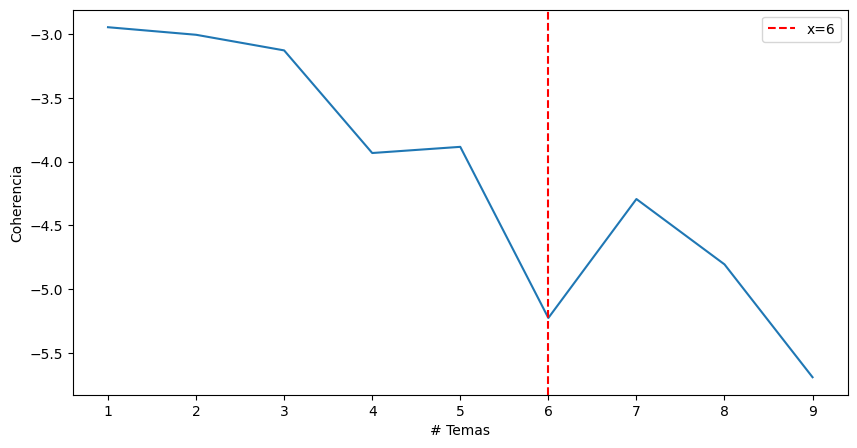

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), tweets_coherence)
plt.xlabel("# Temas")
plt.ylabel("Coherencia")

# Add a vertical line at x=6
plt.axvline(x=6, color='r', linestyle='--', label='x=6')

# Add a legend to show the line label
plt.legend()

# Display the plot
plt.show()


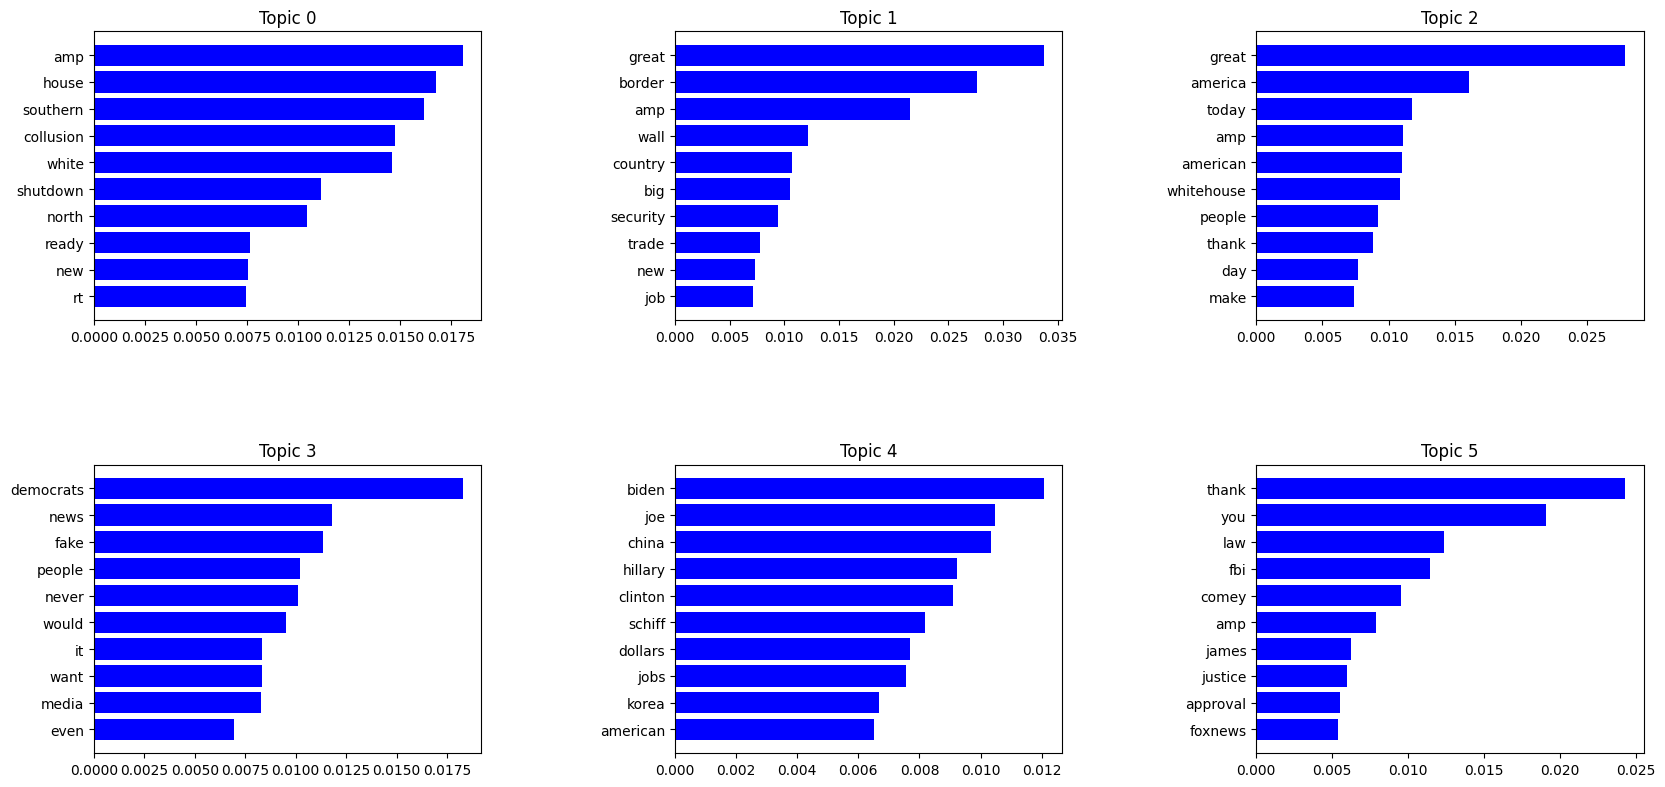

In [8]:
# Importa las bibliotecas necesarias
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Establece el número de temas
k = 6

# Entrena el modelo LDA con el número de temas especificado
tweets_lda = LdaModel(tweets_corpus, num_topics=k, id2word=tweets_dictionary, passes=10)

# Define una función para graficar las palabras principales de cada tema
def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    # Obtiene las palabras principales y sus betas (pesos) para cada tema
    top_words = [[word for word, _ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _, beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    # Configura la cuadrícula para los gráficos
    gs = GridSpec(round(math.sqrt(k)) + 1, round(math.sqrt(k)) + 1)
    gs.update(wspace=0.5, hspace=0.5)

    # Crea una figura y configura el tamaño
    plt.figure(figsize=(20, 15))

    # Itera sobre cada tema
    for i in range(nb_topics):
        # Crea un subplot para el tema actual
        ax = plt.subplot(gs[i])

        # Grafica las palabras principales y sus betas (pesos)
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center', color='blue', ecolor='black')

        # Invierte el eje y y configura las etiquetas
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])

        # Añade un título al subplot
        plt.title("Topic " + str(i))

# Llama a la función para graficar las palabras principales de cada tema
plot_top_words()


In [9]:
import networkx as nx

# Función para crear un grafo de co-ocurrencia a partir de una lista de palabras tokenizadas
def build_co_occurrence_graph(tokenized_texts):
    G = nx.Graph()

    for tokens in tokenized_texts:
        # Considera cada par de palabras en un tweet
        for i in range(len(tokens)):
            for j in range(i+1, len(tokens)):
                if tokens[i] != tokens[j]:
                    if G.has_edge(tokens[i], tokens[j]):
                        G[tokens[i]][tokens[j]]['weight'] += 1
                    else:
                        G.add_edge(tokens[i], tokens[j], weight=1)

    return G

# Construye el grafo a partir de los tweets tokenizados
graph = build_co_occurrence_graph(df_tweets_clean['tokenized_text'])

# Dibuja el grafo
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k=0.1)  # k regula la distancia entre nodos
nx.draw_networkx(graph, pos, node_size=50, edge_color="#444444", alpha=0.05, with_labels=False)
plt.show()

# Analiza el grafo, por ejemplo, calculando la centralidad de grado
degree_centrality = nx.degree_centrality(graph)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by degree centrality:")
for b in sorted_degree_centrality[:10]:
    print(b)


KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>